In [50]:
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
from typing import List
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Read data

In [51]:
def read_file(file_name: str) -> list:
    with open(file_name) as file:
        words = [word.lower() for line in file for word in re.findall(r'[a-zA-Z]+', line)]
        return [word for word in words if word not in stopwords.words('english')]

In [52]:
data = read_file("data/text_book_of_biology_vertebrata.txt")

In [53]:
print(data[:100])

['rabbit', 'external', 'form', 'general', 'considerations', 'section', 'unnecessary', 'enter', 'upon', 'description', 'appearance', 'familiar', 'type', 'perhaps', 'superfluous', 'proceed', 'consider', 'anatomy', 'call', 'attention', 'one', 'two', 'points', 'external', 'externally', 'apparent', 'structure', 'readers', 'know', 'belongs', 'one', 'two', 'primary', 'animal', 'divisions', 'called', 'vertebrata', 'distinctive', 'feature', 'place', 'division', 'possession', 'spinal', 'column', 'backbone', 'really', 'series', 'small', 'ring', 'like', 'bones', 'vertebrae', 'figure', 'v', 'b', 'strung', 'together', 'main', 'nerve', 'axis', 'spinal', 'cord', 'figure', 'c', 'spinal', 'column', 'felt', 'along', 'neck', 'back', 'tail', 'tail', 'small', 'tilted', 'conspicuously', 'white', 'beneath', 'serves', 'recognition', 'mark', 'guide', 'young', 'feeding', 'alarm', 'given', 'bolt', 'made', 'burrows', 'primitive', 'older', 'simpler', 'fashioned', 'vertebrata', 'fishes', 'tail', 'much', 'large', 'fa

## Plot data

In [54]:
def plot(errors: np.ndarray) -> None:
    fig = plt.figure()
    plt.plot(errors)
    plt.xlabel('iterations')
    plt.ylabel('errors')
    plt.show()

## Matrix factorization

In [55]:
class MatrixFactorization(object):
    def __init__(self, matrix: np.ndarray):
        self.__matrix = matrix
        
    def train(self,
              desired_dimensions: int,
              alpha: float= 1e-2,
              beta: float= 1e-2,
              epsilon: float= 1e-5,
              iterations: int= 1e3,
              auto_adjust_initial_values: bool= True):
        self.U = np.random.rand(self.__matrix.shape[0], desired_dimensions)
        self.V = np.random.rand(self.__matrix.shape[1], desired_dimensions)
        
        if auto_adjust_initial_values:
            mean = np.mean(self.__matrix)
            if mean < 1.0:
                self.U *= mean
                self.V *= mean
        
        return self.__gradient_descent(alpha, beta, epsilon, iterations)
       
    def get_predicted_matrix(self):
        return self.U@self.V.T
    
    def get_vector(self, line: int, column: int) -> np.ndarray:
        return self.U[line] * self.V[column]

    def __gradient_descent(self, alpha, beta, epsilon, iterations) -> np.ndarray:
        current_step = 0
        errors = []
        while True:
            error = self.__matrix - self.get_predicted_matrix()
            old_U = self.U.copy()
            
            
            self.U += alpha * (error @ self.V - beta * self.U)
            self.V += alpha * (error.T @ old_U - beta * self.V)
            errors.append(self.__compute_mean_squared_error())
            current_step += 1
            
            if np.linalg.norm(self.U - old_U) < epsilon or current_step > iterations:
                return {
                    'errors' : errors,
                    'iterations' : current_step
                }
    
    def __compute_mean_squared_error(self) -> np.ndarray:
        return np.mean((self.__matrix - self.get_predicted_matrix()) ** 2)

## Test matrix factorization

In [56]:
matrix = np.arange(25).reshape(5, 5)

matrix_fact = MatrixFactorization(matrix)

factorization_result = matrix_fact.train(desired_dimensions= 10)

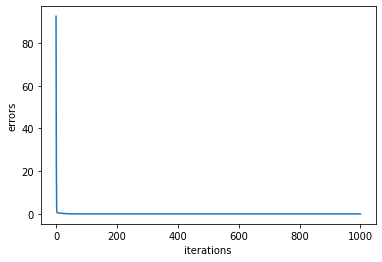

In [57]:
plot(factorization_result['errors'])

In [58]:
print(f'Predicted: \n {np.round(matrix_fact.get_predicted_matrix())}')
print(f'Initial: \n {np.round(matrix)}')

Predicted: 
 [[ 0.  1.  2.  3.  4.]
 [ 5.  6.  7.  8.  9.]
 [10. 11. 12. 13. 14.]
 [15. 16. 17. 18. 19.]
 [20. 21. 22. 23. 24.]]
Initial: 
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]


## Word embedding

In [59]:
class WordEmbedding(object):
    
    def __init__(self, data: List[str]):
        self.__data = data
        
    def train(self,
              window_size,
              desired_dimensions: int,
              alpha: float= 1e-2 ,
              beta: float= 1e-2,
              epsilon: float= 1e-5,
              iterations: int= 1e3,
              auto_adjust_initial_values: bool= True):
        
        self.co_occurrence_matrix = self.__build_co_occurrence_matrix(window_size)
        self.probability_matrix = self.__build_probability_matrix()
        self.__matrix_factorization = MatrixFactorization(matrix= self.probability_matrix)
        training_result = self.__matrix_factorization.train(desired_dimensions, alpha, beta, epsilon, iterations)
        self.__embeddings = self.__matrix_factorization.U * self.__matrix_factorization.V
        self.__words_embeddings = dict(zip(self.__words, self.__embeddings))
        return training_result
        
    def get_predicted_matrix(self) -> np.ndarray:
        return self.__matrix_factorization.get_predicted_matrix()
    
    def get_embeddings(self) -> np.ndarray:
        return self.__embeddings
    
    def get_words_embeddings(self) -> np.ndarray:
        return self.__words_embeddings
    
    def get_words(self) -> np.ndarray:
        return self.__words
        
    def __build_co_occurrence_matrix(self, window_size = (10, 10)) -> np.ndarray:
        self.__words = list(set(self.__data))
        number_of_words = len(self.__words)
        self.__vocab = {word:index for index, word in enumerate(self.__words)}
        number_data = np.array([self.__vocab[word] for word in self.__data])
        
        indices = np.arange(len(number_data))[window_size[0]:-window_size[1]].reshape(-1, 1)
        window = np.concatenate((np.arange(start= -window_size[0], stop= 0, step= 1),
                            np.arange(start= 1, stop= window_size[1] + 1, step= 1)))
        co_occurrence_matrix = np.ones(shape= (number_of_words, number_of_words), dtype= np.float64)
        co_occurrence_matrix[number_data[indices], number_data[indices + window]] += 1/np.abs(window)
        
        return co_occurrence_matrix
        
    def compute_similarity(self, word: str, words_limit: int) -> np.ndarray:
        res = embeddings.get_embeddings()
        if word in self.__vocab:
            word_index = self.__vocab[word]
            cosine_similarity = (res @ res[word_index]) / (np.linalg.norm(res, axis = 1) * np.linalg.norm(res[word_index]))
            indices = np.argsort(cosine_similarity)[::-1]
            return np.c_[np.array(self.__words), cosine_similarity][indices[:words_limit]]
        return None
        
    def __build_probability_matrix(self) -> np.ndarray:
        return self.co_occurrence_matrix / np.sum(self.co_occurrence_matrix, axis= 1, keepdims= True)

In [60]:
embeddings = WordEmbedding(data)

In [61]:
result = embeddings.train(window_size= (2, 2), desired_dimensions= 10, iterations= 10)

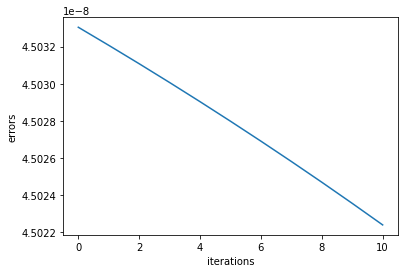

4.502240213726857e-08


In [62]:
plot(result['errors'])
print(result['errors'][-1])

In [66]:
embeddings.compute_similarity('lungs', words_limit= 10)

array([['lungs', '1.0000000000000002'],
       ['diastole', '0.9701851470090653'],
       ['high', '0.9696343480649295'],
       ['lens', '0.9688281626476215'],
       ['depth', '0.9685974375406099'],
       ['sustained', '0.9677610386542096'],
       ['drive', '0.9575141749754035'],
       ['parents', '0.9574087377438077'],
       ['phase', '0.9568288765706253'],
       ['sacculations', '0.955819172840281']], dtype='<U32')

## Visualization

In [67]:
res = embeddings.get_embeddings()
res_norm = (res - np.min(res))/ (np.max(res) - np.min(res))
pca = PCA(n_components=2) #2-dimensional PCA
transformed = pca.fit_transform(res_norm)

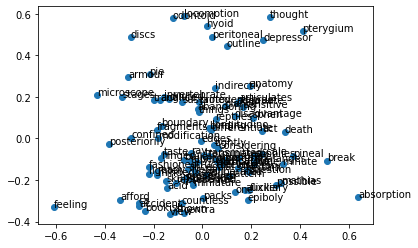

In [68]:
fig, ax = plt.subplots()
x = transformed[:100,0]
y = transformed[:100,1]
words = embeddings.get_words()[:100]
ax.scatter(x, y)

for i, word in enumerate(words):
    ax.annotate(word, (x[i], y[i]))
plt.show()

In [70]:
embeddings.compute_similarity('cell', words_limit= 10)

array([['cell', '1.0000000000000002'],
       ['regard', '0.9778053295129157'],
       ['pump', '0.9738337634081917'],
       ['examined', '0.9736873197190845'],
       ['weak', '0.9536866002677142'],
       ['looking', '0.9529291666082561'],
       ['inconspicuous', '0.9469042750481962'],
       ['dilates', '0.9452077535691932'],
       ['rami', '0.9441129790214087'],
       ['treated', '0.9381771441377548']], dtype='<U32')